In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import foolbox
import torch
from student_net_learning.models.resnet import ResNet50
from foolbox.criteria import TargetClass
from torchvision import transforms
import os
from tqdm import tqdm
import scipy.misc
from skimage.measure import compare_ssim

args = {
    'root':'./data/imgs/',
    'save_root':'./baseline1/',
    'model_name':'ResNet50',
    'checkpoint_path':'./resnet50/best_model_chkpt-resnet50.t7',
}

torchmodel = ResNet50()
checkpoint = torch.load("./student_net_learning/checkpoint/resnet50/best_model_chkpt-resnet50.t7",map_location='cpu')

torchmodel.load_state_dict(checkpoint['net'])

torchmodel.cpu()
torchmodel.eval()

device = torch.device('cpu')

fmodel = foolbox.models.PyTorchModel(torchmodel, bounds=(0, 1), num_classes=512, device=device )

In [2]:
def get_ssim(original_img,changed_img):
    ssim = compare_ssim(np.array(original_img, dtype=np.float32),
                        np.array(changed_img, dtype=np.float32),
                        multichannel=True)
    return ssim

In [3]:
source_img = "./data/imgs/"+"00f5359acf0ddb85976c5a3787ce648f3342ba42"+".jpg"
target_img = "./data/imgs/"+"0adf6f059249e1a8784254f64c4682af33ba3910"+".jpg"

c:\programdata\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
c:\programdata\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


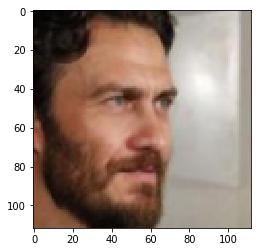

Source Image:  418


In [4]:
original_image=scipy.misc.imread(source_img)
image = scipy.misc.imresize(original_image, (112, 112)).astype(np.float32)
image=image.transpose(2,0,1)/255

plt.imshow(image.transpose((1,2,0)))
plt.show()
label = np.argmax(fmodel.predictions(image))
print("Source Image: " , label)

c:\programdata\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
c:\programdata\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


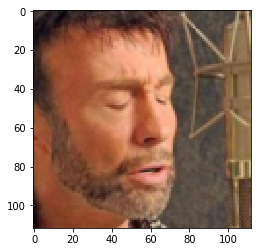

Target Image 337


In [5]:
target_image=scipy.misc.imread(target_img)
target_image1 = scipy.misc.imresize(target_image, (112, 112)).astype(np.float32)
target_image1=target_image1.transpose(2,0,1)/255

plt.imshow(target_image1.transpose((1,2,0)))
plt.show()
target_label = np.argmax(fmodel.predictions(target_image1))
print("Target Image" , target_label)

In [6]:
from foolbox.criteria import TargetClassProbability
target_class = target_label
criterion=TargetClassProbability(target_class, p=.9)
attack = foolbox.attacks.FGSM(fmodel, criterion)

In [7]:
adversarial = attack(image, label=label)

In [8]:
label_after = np.argmax(fmodel.predictions(adversarial))
print("\nbefore: {}\n after: {}\n ssim: {}".format(label, label_after, get_ssim(image.transpose((1,2,0)),adversarial.transpose(1,2,0))))


before: 418
 after: 361
 ssim: 0.9998823014196999


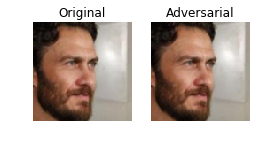

In [9]:
plt.figure()

plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(image.transpose((1,2,0)))  # division by 255 to convert [0, 255] to [0, 1]
plt.axis('off')

adversarial1=adversarial.transpose((1,2,0))
plt.subplot(1, 3, 2)
plt.title('Adversarial')
plt.imshow( adversarial1)  # division by 255 to convert [0, 255] to [0, 1]
plt.axis('off')

plt.show()

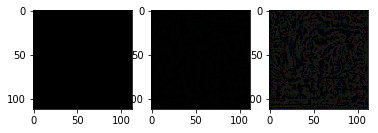

In [10]:
#calculate perturbation 
div = image.transpose((1,2,0)) - adversarial1
divT = np.transpose(div, (1, 0, 2))

plt.subplot(131)
plt.imshow(divT*1)

plt.subplot(132)
plt.imshow(divT*10)

plt.subplot(133)
plt.imshow(divT*100)
plt.show()

In [11]:
l2_dist = np.sqrt(np.sum((div)**2))/np.sqrt(np.sum((image)**2))
print("L2 Distance:",l2_dist)

L2 Distance: 0.0016522438


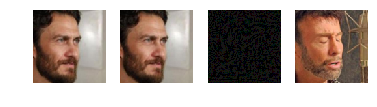

In [12]:
plt.subplot(141)
plt.imshow(image.transpose((1,2,0)))
plt.axis('off')

plt.subplot(142)
plt.imshow(adversarial1)
plt.axis('off')

plt.subplot(143)
plt.imshow(divT*100)
plt.axis('off')

plt.subplot(144)
plt.imshow(target_image1.transpose((1,2,0)))
plt.axis('off')

plt.show()